In [1]:
import io
import os
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
font = {'weight': 'bold'
       ,'size': 16}
plt.rc('font', **font)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error,r2_score, make_scorer, roc_auc_score, roc_curve, auc, recall_score

In [2]:
aws_id = os.environ['AWS_ACCESS_KEY_ID']
aws_secret = os.environ['AWS_SECRET_ACCESS_KEY']
client = boto3.client('s3'
                     ,aws_access_key_id=aws_id
                     ,aws_secret_access_key=aws_secret)

train_obj = client.get_object(Bucket='food-delivery-churn', Key='churn_train.csv')
test_obj = client.get_object(Bucket='food-delivery-churn', Key='churn_test.csv')

In [3]:
churn_train_X = pd.read_csv(io.BytesIO(train_obj['Body'].read())
                            ,encoding='utf8'
                            ,parse_dates=['signup_time_utc', 'last_order_time_utc']
                            ,date_parser=pd.to_datetime)

churn_test_X = pd.read_csv(io.BytesIO(test_obj['Body'].read())
                            ,encoding='utf8'
                            ,parse_dates=['signup_time_utc', 'last_order_time_utc']
                            ,date_parser=pd.to_datetime)

In [4]:
churn_train_y = churn_train_X.pop('churned_user').values
churn_test_y = churn_test_X.pop('churned_user').values

In [7]:
churn_train_X_drop = churn_train_X.drop(['user_id', 'signup_time_utc', 'last_order_time_utc'], axis=1)
churn_test_X_drop = churn_test_X.drop(['user_id', 'signup_time_utc', 'last_order_time_utc'], axis=1)

select_columns = ['signup_to_order_hours'
                 ,'first_order_discount_percent'
                 ,'first_30_day_orders'
                 ,'first_30_day_avg_meal_rating'
                 ,'first_30_day_avg_driver_rating'
                 ,'first_30_day_discount_percent']
# churn_train_X_drop.loc[:, churn_train_X_drop.columns.to_series().str.startswith("first_30")]
# churn_train_X_drop.columns.to_series().str.startswith(("first_30", "city", "signup"))
churn_train_X_drop.select_dtypes(include=['object']).columns.tolist()

['city_name', 'city_group']

In [27]:
def convert_cat_to_int(data, col):
    '''
    Args:
        data (Pandas DF): A pandas DF with a column 'col' to convert string/boolean values to integers
        col (str) = The name of the column to convert from categorical to integer
        
    Returns:
        data (Pandas DF): A pandas DF with t
    '''
    col_dict = {}
    for idx, cat in enumerate(data[col].unique()):
        col_dict[cat] = idx

    data[col] = data[col].map(lambda x: col_dict[x])

    return data

In [28]:
churn_train_X_drop = convert_cat_to_int(churn_train_X_drop, 'city_name')
churn_train_X_drop = convert_cat_to_int(churn_train_X_drop, 'city_group')
churn_train_X_drop = convert_cat_to_int(churn_train_X_drop, 'first_order_delivered_on_time')

churn_test_X_drop = convert_cat_to_int(churn_test_X_drop, 'city_name')
churn_test_X_drop = convert_cat_to_int(churn_test_X_drop, 'city_group')
churn_test_X_drop = convert_cat_to_int(churn_test_X_drop, 'first_order_delivered_on_time')


In [29]:
X_train = churn_train_X_drop.values
y_train = churn_train_y

X_test = churn_test_X_drop.values
y_test = churn_test_y

In [30]:
lr_model = LogisticRegression(solver='liblinear', class_weight='balanced')
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', solver='liblinear')

In [31]:
y_hats = lr_model.predict(X_test)

In [32]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hats).ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
print(\
f"---------------------------------\n"\
f"          |        True         |\n"\
f"Predicted |  {tp}   |    {fp}  |\n"\
f"          |  {fn}    |    {tn}  |\n"\
f"---------------------------------")

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"AUC: {roc_auc_score(y_test, y_hats):.4f}")

---------------------------------
          |        True         |
Predicted |  19147   |    3521  |
          |  7147    |    4468  |
---------------------------------
Accuracy: 0.6888
Recall: 0.7282
Precision: 0.8447
AUC: 0.6437


In [33]:
# mean_squared_error
# r2_score
# make_scorer
roc_curve(y_test, y_hats)
# auc
# recall_score

(array([0.        , 0.44073101, 1.        ]),
 array([0.        , 0.72818894, 1.        ]),
 array([2, 1, 0]))

In [34]:
def plot_model_aoc(classifier, X_test, y_test, ax, plot_kwargs={}):
    """ Plots the AOC Curve for a classifier given the test data and axis
    Args:
        classifier (Sklearn Classifier): The best classifier to test against other classifiers
        X_test (numpy array): Values to use when predicting with the classifier
        y_test (numpy array): True target values to evaluate the predictors against
        ax (matplotlib axis): An axis to plot the AOC curve on.

    Returns: 
        None
        Modifies ax by plotting the AOC curve from the best classifier.
    """
    y_preds = classifier.predict_proba(X_test)[:,1] 
    auc_score = roc_auc_score(y_test, y_preds)
    fpr, tpr, threshold = roc_curve(y_test, y_preds)
    roc_df = pd.DataFrame(zip(fpr, tpr, threshold), columns = ['fpr', 'tpr', 'threshold'])
    ax.plot(roc_df.fpr, roc_df.tpr, label=f"{classifier.__class__.__name__} AUC={auc_score:.3f}", **plot_kwargs)

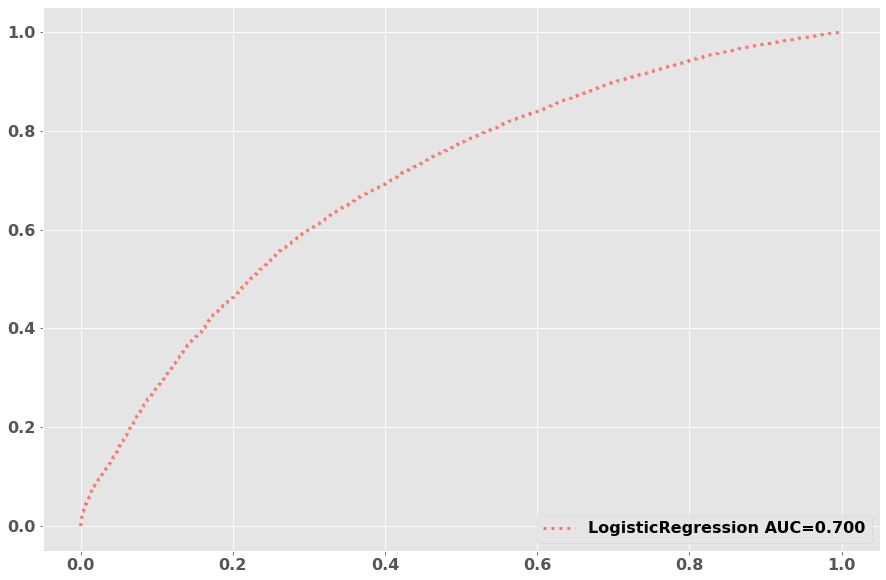

In [46]:
fig, ax = plt.subplots(figsize=(15,10))

plot_model_aoc(lr_model, X_test, y_test, ax, plot_kwargs={'linestyle':':'
                                                          ,'linewidth': 3
                                                          ,'color': '#F8766D'})
ax.legend(loc='lower right')